In [1]:
import os
import math
import pandas as pd

def calculate_h_index(quotation): #h_ndex
    quotation.sort(reverse=True)  # 논문을 내림차순으로 정렬

    h_index = 0
    for i, quotation in enumerate(quotation):
        if quotation >= i + 1:
            h_index = i + 1
        else:
            break

    return h_index

def calculate_i10_index(quotation):  #i10_index
    i10_index = sum(1 for quotation in quotation if quotation >= 10)
    return i10_index

def calculate_g_index(quotation):  #g_index
    quotation.sort(reverse=True)  # 논문을 내림차순으로 정렬

    g_index = 0
    quotation_sum=0
    for i, quotation in enumerate(quotation):
        quotation_sum+=quotation
        if quotation_sum >= (i + 1)**2:
            g_index = i + 1

    return g_index

#Object 타입에서 숫자형 체크용
def is_numeric(value):
    try:
        float(value)  # float으로 변환 가능한 경우 숫자
        return True
    except (ValueError, TypeError):
        return False

def recentness(pYears):
    # dt = datetime.datetime.now()#현재날짜
    dt = 2013
    rct = 0
    lct = 0
    if len(pYears) == 0:
        rct = 0
        lct = 0
    else:
        year_avg = sum(pYears) / len(pYears) # 2002.5
        if year_avg >= int(dt)-2: #int(dt.year)-2:
            lct = 1
        else:
            lct = max(round((1-(int(dt)-3-year_avg)*0.1),2), 0)
        # elif int(dt)-15 < year_avg <= int(dt)-3:
        #     lct = max(round((1-(int(dt)-3-year_avg)*0.1),2), 0)

        rct += len(pYears) #연도 개수

    return rct, lct

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', None)

In [2]:
#authors.all 파일 위치 주소
authors_file_path = r"./gsc_data/authors.all"

try:
    with open(authors_file_path, 'r', encoding='cp1252') as file:
        lines = file.read().splitlines()
        data = [line.split('|') for line in lines]
        columns = ["Valid", "Name", "Affiliation", "Email Domain", "Citation Count", "ID"]
        df_a = pd.DataFrame(data,columns=columns) # authors 의 a
        # df_a = df_a.drop(columns=["C6", "C7"])
        print("변환 완료")
except FileNotFoundError:
    print("파일을 찾을 수 없습니다.")
except UnicodeDecodeError:
    print("파일을 ANSI(Windows-1252) 인코딩으로 열 수 없습니다.")
    
df_a_copy = df_a.copy()  # df_a의 복사본 생성


for index, row in df_a_copy.iterrows():
    if pd.isna(row[5]):  
        if pd.isna(row[4]):
            if pd.isna(row[3]):  # 1의 경우
                row[5] = row[2] 
            else:  # 2,3,4 의 경우
                row[5] = row[3]
                if is_numeric(row[2]): # 4의 경우
                    row[4] = row[2]
                    row[2] = None
                    row[3] = None
                elif '.' in str(row[2]):  # 3의 경우
                    row[3] = row[2]
                    row[2] = None
                    row[4] = None
                else: # 2의 경우
                    row[3] = None
        else:  # 5,6,7 의 경우
            row[5] = row[4] 
            if is_numeric(row[3]): # 6,7 의 경우
                row[4] = row[3]
                if '.' in str(row[2]): # 7 의 경우
                    row[3] = row[2]
                    row[2] = None
                else: # 6의 경우
                    
                    row[3] = None
            else: #5의 경우
                row[4] = None

변환 완료


In [3]:
Author_df=df_a_copy.drop(columns=['Valid', 'Affiliation', 'Email Domain'])
     
# print(Author_df)

In [33]:
#gsc_data\DATA 폴더 경로
folder_path = r"./gsc_data/DATA/"

id_year_cit={}
id_year_cit_df=[]
# df_a_copy의 각 행에서 1번 열의 값을 추출
for index, row in df_a_copy.iterrows():
    name = row.iloc[5]  # 1번 열의 값

    converted_list=[]
    citations = [] #인용수
    years = [] #연도

    # 파일 경로 생성
    file_path = os.path.join(folder_path, name + "_.dat")
   
    # 파일이 존재하는지 확인
    if os.path.exists(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            # 파일의 각 줄을 읽어 리스트로 저장
            lines = file.readlines()
 
        # 각 줄을 나누어서 리스트로 저장
        cit_year_list = [line.strip().split('|') for line in lines]

        citations = [] #인용수
        years = [] #연도

        for line_list in cit_year_list:
            citations.append(int(line_list[0]))
            years.append(int(line_list[1]))

        year_count = {} #각 연도 별 논문 수

        for year in years:
            if year in year_count:
                year_count[year] += 1
            else:
                year_count[year] = 1

        sorted_year_count = dict(sorted(year_count.items()))
        frequency_list = list(sorted_year_count.values())

        year_cit_df = pd.DataFrame({'Year': years,'citation': citations})

        grouped_df = year_cit_df.groupby('Year', as_index=False)['citation'].sum()
        grouped_df['Paper_Count']=frequency_list
        # converted_list = grouped_df.values.tolist()

    else:
        print(f"파일을 찾을 수 없습니다: {file_path}")

    id_year_cit[name]={'year_citation': grouped_df}


    grouped_df_copy = grouped_df.copy()
    grouped_df_copy['ID']=name
    id_year_cit_df.append(grouped_df_copy)

In [34]:
merged_df = pd.concat(id_year_cit_df, ignore_index=True)
merged_df['Year'] = merged_df['Year'].astype(int)
merged_df['citation'] = merged_df['citation'].astype(int)
merged_df['Paper_Count'] = merged_df['Paper_Count'].astype(int)

new_order = ['ID', 'Year', 'Paper_Count', 'citation']
merged_df = merged_df[new_order]

In [ ]:
# merged_df.to_csv(f"C:/Users/isjun/바탕 화면/연구실/전문가 검색/year_citation_papercnt_all/year_citation_papercnt.csv", index=False)

In [23]:
# for index, row in df_a_copy.iterrows():
#     name = row.iloc[5]  # 1번 열의 값
#     id_year_cit[name]['year_citation'].to_csv(f"C:/Users/isjun/바탕 화면/연구실/전문가 검색/year_citation_papercnt/{name}.csv", index=False)

In [77]:
print(id_year_cit['ZbDSeuAAAAAJ']['year_citation'])

   Year  citation  Paper_Count
0  2003         0            2
1  2004        19            2
2  2006        18            6
3  2007        36            5
4  2008         4            2
5  2009        72            3
6  2010       760           17
7  2011      1021           62
8  2012       162           56


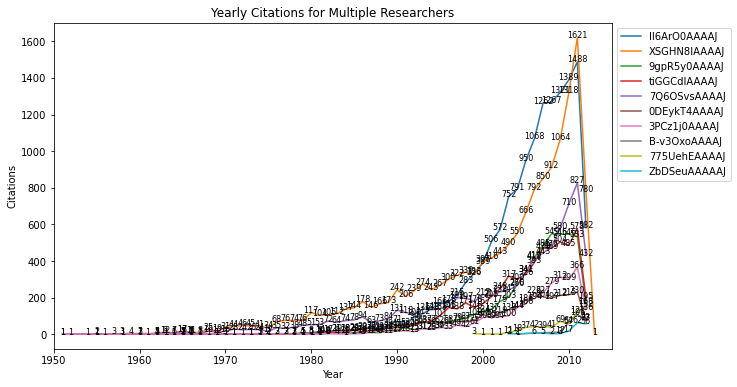

In [75]:
import matplotlib.pyplot as plt

starty, endy = 1950, 2015
plt.figure(figsize=(10, 6))

id_wlist = ['Il6ArO0AAAAJ', 'XSGHN8IAAAAJ', '9gpR5y0AAAAJ', 'tiGGCdIAAAAJ', '7Q6OSvsAAAAJ', '0DEykT4AAAAJ', '3PCz1j0AAAAJ', 'B-v3OxoAAAAJ', '775UehEAAAAJ', 'ZbDSeuAAAAAJ']
# id_hlist = ['M5_mEHQAAAAJ', 'E2-uIQYAAAAJ', 'OU05Q_MAAAAJ', 'F4P3ghEAAAAJ', 'C_dhdvAAAAAJ', 'Il6ArO0AAAAJ', 'rMgCyBUAAAAJ', 'g-_ZXGsAAAAJ', 'Jde99xEAAAAJ', '1fatN9EAAAAJ']
# id_ilist = ['Il6ArO0AAAAJ', '9gpR5y0AAAAJ', 'XSGHN8IAAAAJ', '0DEykT4AAAAJ', 'tiGGCdIAAAAJ', 'E2-uIQYAAAAJ', 'M5_mEHQAAAAJ', 'rMgCyBUAAAAJ', '1fatN9EAAAAJ', 'LYz-mFwAAAAJ']
# id_glist = ['M5_mEHQAAAAJ', 'ZpG_cJwAAAAJ', 'vsj2slIAAAAJ', 'AKqYlxMAAAAJ', 'd_lp40IAAAAJ', 'kYC-FxkAAAAJ', 'OU05Q_MAAAAJ', 'F4P3ghEAAAAJ', 'E2-uIQYAAAAJ', 'C_dhdvAAAAAJ']
for value in id_wlist:
    year = id_year_cit[value]['year_citation']['Year']
    # year = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
    # citation = id_year_cit[value]['year_citation']['citation']
    paperc = id_year_cit[value]['year_citation']['Paper_Count']
    # plt.plot(year, paperc)
    # for i in range(len(year)):
    #     plt.text(year[i], paperc[i], str(paperc[i]), fontsize=8, ha='center')
    # x 범위 내 데이터만 필터링
    filtered_data = [(y, c) for y, c in zip(year, paperc) if starty <= y <= endy]
    filtered_year, filtered_paperc = zip(*filtered_data) if filtered_data else ([], [])
    
    plt.plot(filtered_year, filtered_paperc, label=value)
    for i in range(len(filtered_year)):
        plt.text(filtered_year[i], filtered_paperc[i], str(filtered_paperc[i]), fontsize=8, ha='center')

plt.xlabel('Year')
plt.ylabel('Citations')
plt.title('Yearly Citations for Multiple Researchers')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.xlim(starty, endy)
plt.show()